Table 1: Comarison with the Robust Baselines (Linear+Robust, SVM, NN+Robust)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import HuberRegressor, RANSACRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import pandas as pd

# NN Definition
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim=2, activation_func='sigmoid'):
        super(NeuralNetwork, self).__init__()
        self.first = nn.Linear(input_dim, 100)
        self.hidden1 = nn.Linear(100, 100)
        self.hidden2 = nn.Linear(100, 100)
        self.hidden3 = nn.Linear(100, 100)
        self.output = nn.Linear(100, 1)
        if activation_func == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            self.activation = nn.ReLU()
    def forward(self, x):
        x = self.activation(self.first(x))
        x = self.activation(self.hidden1(x))
        x = self.activation(self.hidden2(x))
        x = self.activation(self.hidden3(x))
        return self.output(x)

# HOVR
def hovr_regularization(model, x, k=3, q=2, M=10):
    x_min, x_max = x.min(0)[0], x.max(0)[0]
    random_points = torch.tensor(
        np.random.uniform(x_min.numpy(), x_max.numpy(), (M, x.shape[1])),
        dtype=torch.float32, requires_grad=True)
    preds = model(random_points)
    grads = torch.autograd.grad(preds, random_points, torch.ones_like(preds),
                                create_graph=True)[0]
    hovr_term = 0.0
    n_dims = x.shape[1]
    for i in range(n_dims):
        grad_i = grads[:, i]
        temp_grad = grad_i
        for _ in range(k - 1):
            temp_grad = torch.autograd.grad(temp_grad, random_points,
                                            torch.ones_like(temp_grad),
                                            create_graph=True)[0][:, i]
        hovr_term += (1 / n_dims) * torch.sum(torch.abs(temp_grad) ** q)
    return hovr_term

# TTL+HOVR (=ARTL)
def transformed_ttl_hovr_loss(model, xi, x, y, h, lambd, k, q):
    n = x.shape[0]
    preds = model(x)
    residuals = (y - preds).view(-1, 1)
    loss_fit = (1 / n) * torch.sum((residuals - xi) ** 2)
    xi_squared = xi.view(-1) ** 2
    T_h_xi = (1 / n) * torch.sum(torch.topk(xi_squared, h,
                                            largest=False)[0])
    hovr_term = lambd * hovr_regularization(model, x, k, q)
    total_loss = loss_fit + T_h_xi + hovr_term
    return total_loss

def plot_prediction_surface(X, y, predict_func, title, outlier_indices, true_function):
    x1_grid, x2_grid = np.meshgrid(np.linspace(0, 2*np.pi, 100),
                                   np.linspace(0, 2*np.pi, 100))
    X_grid = np.vstack((x1_grid.flatten(), x2_grid.flatten())).T
    y_grid_pred = predict_func(X_grid).reshape(x1_grid.shape)
    plt.figure(figsize=(4, 3))
    plt.contourf(x1_grid, x2_grid, y_grid_pred, levels=20, cmap='viridis')
    plt.colorbar()
    plt.scatter(X[:, 0], X[:, 1], c='white', edgecolors='black')
    plt.scatter(X[outlier_indices, 0], X[outlier_indices, 1],
                c='red', edgecolors='black')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(f'{title}')
    plt.show()

# Dataset Generation (4 types)
def generate_data(n=100, noise_std=0.2, outlier_ratio=0.03, true_function='sin_cos'):
    x1 = np.linspace(0, 2*np.pi, int(np.sqrt(n)))
    x2 = np.linspace(0, 2*np.pi, int(np.sqrt(n)))
    x1_grid, x2_grid = np.meshgrid(x1, x2)
    x1_flat, x2_flat = x1_grid.flatten(), x2_grid.flatten()
    X = np.vstack((x1_flat, x2_flat)).T
    if true_function == 'checkered':
        y_true = np.sin(2 * x1_flat) * np.cos(2 * x2_flat)
    elif true_function == 'volcano':
        y_true = np.exp(-((np.sqrt((x1_flat - np.pi)**2 + (x2_flat - np.pi)**2) - np.pi / 2)**2))
    elif true_function == 'stripe':
        y_true = np.sin(2 * (x1_flat + x2_flat))
    elif true_function == 'plane':
        y_true = x1_flat - x2_flat
    else:
        raise ValueError('Invalid true function specified.')
    y = y_true + np.random.normal(0, noise_std, x1_flat.shape[0])
    n_outliers = int(n * outlier_ratio)
    random_indices = np.random.choice(n, n_outliers, replace=False)
    y[random_indices] = 5 + np.random.uniform(-0.1, 0.1, n_outliers)
    return X, y, y_true, random_indices

# Evaluation
def evaluate_methods(true_function):
    pmse_results = []
    for trial in range(5):
        X, y, y_true, outlier_indices = generate_data(true_function=true_function)
        n_test = 10**4
        x1_test = np.linspace(0, 2 * np.pi, n_test)
        x2_test = np.linspace(0, 2 * np.pi, n_test)
        X_test = np.vstack((x1_test, x2_test)).T
        if true_function == 'checkered':
            y_test_true = np.sin(2 * x1_test) * np.cos(2 * x2_test)
        elif true_function == 'volcano':
            y_test_true = np.exp(-((np.sqrt((x1_test - np.pi)**2 + (x2_test - np.pi)**2) - np.pi / 2)**2))
        elif true_function == 'stripe':
            y_test_true = np.sin(2 * (x1_test + x2_test))
        elif true_function == 'plane':
            y_test_true = x1_test - x2_test
        else:
            raise ValueError('Invalid true function specified.')
        methods = [
            ('Linear with Huber Loss', huber_regression),
            ('Linear with RANSAC', ransac_regression),
            ('SVR with RBF Kernel', svr_rbf_kernel),
            ('NN with Huber Loss', nn_huber_loss),
            ('NN with Tukey Loss', nn_tukey_loss),
            ('NN with RANSAC', nn_ransac_like),
            ('NN with Label Noise Reg.', label_noise_regularization),
            ('NN with TTL(10%)+HOVR(k=1)', lambda X, y, X_test, y_test_true, trial,
             outlier_indices, true_function: ttl_hovr(X, y, X_test, y_test_true, trial,
             outlier_indices, k=1, h_factor=0.9, true_function=true_function)),
            ('NN with TTL(10%)+HOVR(k=2)', lambda X, y, X_test, y_test_true, trial,
             outlier_indices, true_function: ttl_hovr(X, y, X_test, y_test_true, trial,
             outlier_indices, k=2, h_factor=0.9, true_function=true_function)),
        ]
        for method_name, method_function in methods:
            pmse = method_function(X, y, X_test, y_test_true, trial,
                                   outlier_indices, true_function)
            pmse_results.append({'method': method_name,
                                 'trial': trial + 1, 'pmse': pmse,
                                 'true_function': true_function})
    df_results = pd.DataFrame(pmse_results)
    summary = df_results.groupby(['true_function', 'method'])['pmse'].agg(['mean', 'std'])
    print(f"Results for true function: {true_function}")
    print(summary)
    return df_results

# Implementaton of Baselines/Proposal
def huber_regression(X, y, X_test, y_test_true, trial, outlier_indices, true_function):
    model = HuberRegressor()
    model.fit(X, y)
    y_pred = model.predict(X_test)
    pmse = mean_squared_error(y_test_true, y_pred)
    if trial == 0:
        plot_prediction_surface(X, y, model.predict, 'Linear with Huber Loss',
                                outlier_indices, true_function)
    return pmse

def ransac_regression(X, y, X_test, y_test_true, trial, outlier_indices, true_function):
    model = RANSACRegressor()
    model.fit(X, y)
    y_pred = model.predict(X_test)
    pmse = mean_squared_error(y_test_true, y_pred)
    if trial == 0:
        plot_prediction_surface(X, y, model.predict, 'Linear with RANSAC',
                                outlier_indices, true_function)
    return pmse

def svr_rbf_kernel(X, y, X_test, y_test_true, trial, outlier_indices, true_function):
    model = SVR(kernel='rbf')
    model.fit(X, y)
    y_pred = model.predict(X_test)
    pmse = mean_squared_error(y_test_true, y_pred)
    if trial == 0:
        plot_prediction_surface(X, y, model.predict, 'SVR with RBF Kernel',
                                outlier_indices, true_function)
    return pmse

def nn_huber_loss(X, y, X_test, y_test_true, trial, outlier_indices, true_function):
    model = NeuralNetwork()
    criterion = nn.SmoothL1Loss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)
    epochs = 5000
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)
        loss.backward()
        optimizer.step()
        scheduler.step()  # updating the learning rate
    with torch.no_grad():
        y_pred = model(torch.tensor(X_test, dtype=torch.float32)).numpy().flatten()
    pmse = mean_squared_error(y_test_true, y_pred)
    if trial == 0:
        predict_func = lambda X_new: model(torch.tensor(X_new,
                        dtype=torch.float32)).detach().numpy().flatten()
        plot_prediction_surface(X, y, predict_func, 'NN with Huber Loss',
                                outlier_indices, true_function)
    return pmse

def nn_tukey_loss(X, y, X_test, y_test_true, trial, outlier_indices, true_function):
    def tukey_loss(output, target, c=4.685):
        residual = target - output
        abs_residual = torch.abs(residual)
        mask = abs_residual <= c
        loss = torch.zeros_like(residual)
        loss[mask] = (c**2 / 6)*(1 - (1 - (residual[mask]/c)**2)**3)
        loss[~mask] = (c**2 / 6)
        return torch.mean(loss)
    model = NeuralNetwork()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    # ステップ減衰を導入
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)
    epochs = 5000
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_tensor)
        loss = tukey_loss(outputs, y_tensor)
        loss.backward()
        optimizer.step()
        scheduler.step()  # updating the learning rate
    with torch.no_grad():
        y_pred = model(torch.tensor(X_test, dtype=torch.float32)).numpy().flatten()
    pmse = mean_squared_error(y_test_true, y_pred)
    if trial == 0:
        predict_func = lambda X_new: model(torch.tensor(X_new,
                        dtype=torch.float32)).detach().numpy().flatten()
        plot_prediction_surface(X, y, predict_func, 'NN with Tukey Loss',
                                outlier_indices, true_function)
    return pmse

def nn_ransac_like(X, y, X_test, y_test_true, trial, outlier_indices, true_function):
    model = NeuralNetwork()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)
    X_t = torch.tensor(X, dtype=torch.float32)
    y_t = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)
    for epoch in range(1000):
        optimizer.zero_grad()
        outputs = model(X_t)
        loss = nn.MSELoss()(outputs, y_t)
        loss.backward()
        optimizer.step()
        scheduler.step()  # updating the learning rate
    with torch.no_grad():
        residuals = torch.abs(y_t - model(X_t))
    threshold = torch.quantile(residuals, 0.90)
    inliers = residuals <= threshold
    X_inliers = X_t[inliers.view(-1)]
    y_inliers = y_t[inliers]
    for epoch in range(5000):
        optimizer.zero_grad()
        outputs = model(X_inliers)
        loss = nn.MSELoss()(outputs, y_inliers)
        loss.backward()
        optimizer.step()
        scheduler.step()  # updating the learning rate
    with torch.no_grad():
        y_pred = model(torch.tensor(X_test, dtype=torch.float32)).numpy().flatten()
    pmse = mean_squared_error(y_test_true, y_pred)
    if trial == 0:
        predict_func = lambda X_new: model(torch.tensor(X_new,
                        dtype=torch.float32)).detach().numpy().flatten()
        plot_prediction_surface(X, y, predict_func, 'NN with RANSAC',
                                outlier_indices, true_function)
    return pmse

def label_noise_regularization(X, y, X_test, y_test_true, trial,
                               outlier_indices, true_function):
    model = NeuralNetwork()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5) # step decay
    criterion = nn.MSELoss()
    X_t = torch.tensor(X, dtype=torch.float32)
    y_t = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)
    smoothing = 0.1
    epochs = 5000
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_t)
        targets_smoothed = y_t * (1 - smoothing) + smoothing * y_t.mean()
        loss = criterion(outputs, targets_smoothed)
        loss.backward()
        optimizer.step()
        scheduler.step()  # updating the learning rate
    with torch.no_grad():
        y_pred = model(torch.tensor(X_test, dtype=torch.float32)).numpy().flatten()
    pmse = mean_squared_error(y_test_true, y_pred)
    if trial == 0:
        predict_func = lambda X_new: model(torch.tensor(X_new,
                        dtype=torch.float32)).detach().numpy().flatten()
        plot_prediction_surface(X, y, predict_func,
                                'NN with Label Noise Reg.',
                                outlier_indices, true_function)
    return pmse

def ttl_hovr(X, y, X_test, y_test_true, trial, outlier_indices, k, h_factor, true_function):
    model = NeuralNetwork()
    n_params = X.shape[0]
    xi = nn.Parameter(torch.zeros(n_params, 1), requires_grad=True)
    optimizer = optim.Adam(list(model.parameters()) + [xi], lr=0.01)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)
    X_t = torch.tensor(X, dtype=torch.float32)
    y_t = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)
    h = int(h_factor * n_params)
    lambd = 1e-3
    q = 2
    epochs = 5000
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = transformed_ttl_hovr_loss(model, xi, X_t, y_t, h, lambd, k, q)
        loss.backward()
        optimizer.step()
        scheduler.step()  # updating the learning rate
    with torch.no_grad():
        y_pred = model(torch.tensor(X_test, dtype=torch.float32)).numpy().flatten()
    pmse = mean_squared_error(y_test_true, y_pred)
    if trial == 0:
        predict_func = lambda X_new: model(torch.tensor(X_new,
                        dtype=torch.float32)).detach().numpy().flatten()
        title = f'NN with TTL({h_factor}n)+HOVR(k={k})'
        plot_prediction_surface(X, y, predict_func, title, outlier_indices, true_function)
    return pmse

true_functions = ['plane','checkered','volcano', 'stripe']
all_results = []
for func in true_functions:
    results = evaluate_methods(func)
    all_results.append(results)

df_all_results = pd.concat(all_results, ignore_index=True)
summary_all = df_all_results.groupby(['true_function', 'method'])['pmse'].agg(['mean', 'std']).reset_index()
print(summary_all)

Contour Plot of True Functions (in Figure 6-9 in Supplement)

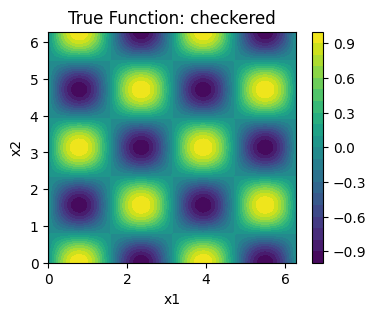

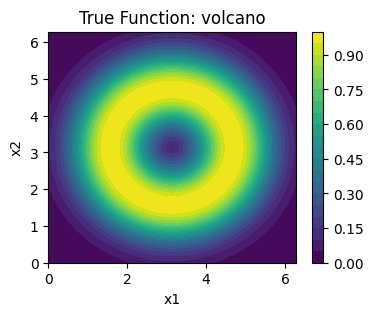

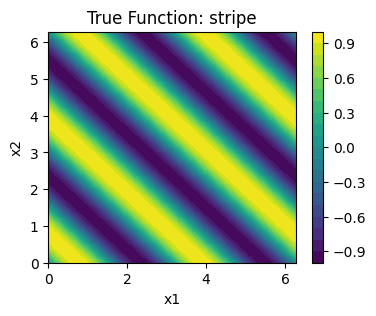

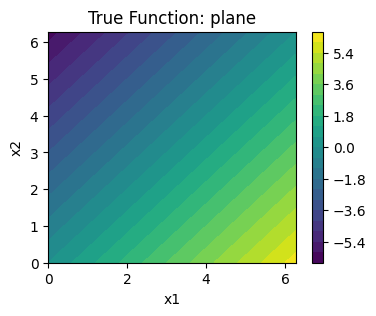

In [ ]:
# Plot the contour plots of all the true functions
x1_lin = np.linspace(0, 2 * np.pi, 100)
x2_lin = np.linspace(0, 2 * np.pi, 100)
x1_grid_full, x2_grid_full = np.meshgrid(x1_lin, x2_lin)
X_grid_full = np.vstack((x1_grid_full.flatten(), x2_grid_full.flatten())).T

true_functions = ['checkered','volcano', 'stripe', 'plane']

for true_function in true_functions:

  if true_function == 'checkered':
    y_true_full = np.sin(2 * X_grid_full[:, 0]) * np.cos(2 * X_grid_full[:, 1])
  elif true_function == 'volcano':
    y_true_full = np.exp(-((np.sqrt((X_grid_full[:,0] - np.pi)**2 + (X_grid_full[:,1] - np.pi)**2) - np.pi / 2)**2))
  elif true_function == 'stripe':
    y_true_full = np.sin(2 * (X_grid_full[:,0] + X_grid_full[:,1]))
  elif true_function == 'plane':
    y_true_full = X_grid_full[:,0] - X_grid_full[:,1]
  y_true_full = y_true_full.reshape(x1_grid_full.shape)

  plt.figure(figsize=(4, 3))
  plt.contourf(x1_grid_full, x2_grid_full, y_true_full, levels=20, cmap='viridis')
  plt.colorbar()
  plt.title(f'True Function: {true_function}')
  plt.xlabel('x1')
  plt.ylabel('x2')
  plt.show()

3D Plot of True Functions (in Figure 5 in Supplement)

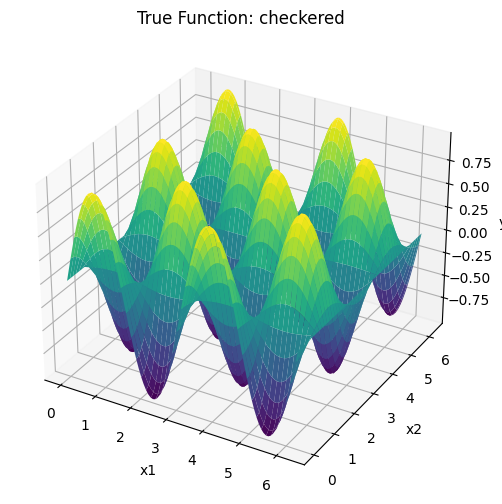

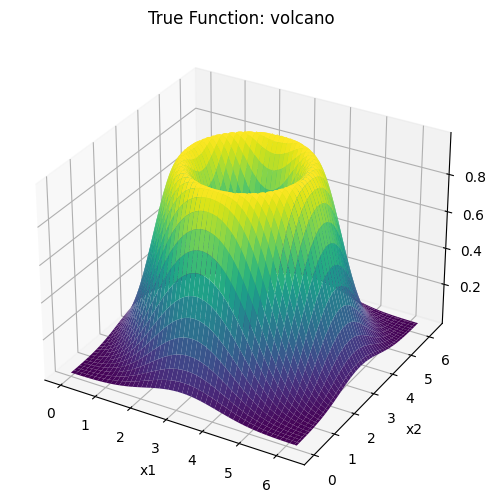

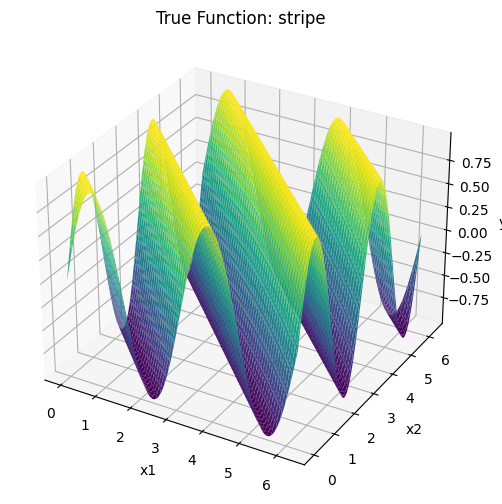

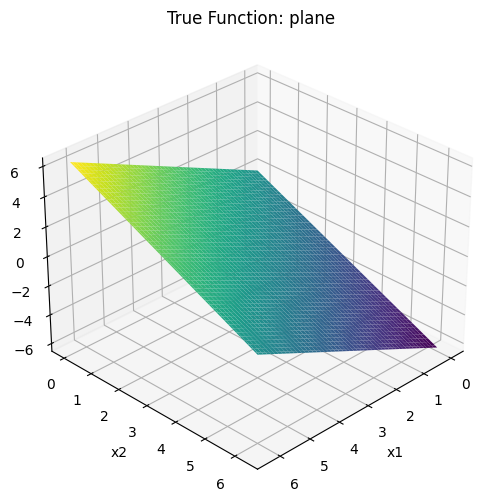

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting

# Generate the grid
x1_lin = np.linspace(0, 2 * np.pi, 100)
x2_lin = np.linspace(0, 2 * np.pi, 100)
x1_grid_full, x2_grid_full = np.meshgrid(x1_lin, x2_lin)
X_grid_full = np.vstack((x1_grid_full.flatten(), x2_grid_full.flatten())).T

true_functions = ['checkered', 'volcano', 'stripe', 'plane']

for true_function in true_functions:

    if true_function == 'checkered':
        y_true_full = np.sin(2 * X_grid_full[:, 0]) * np.cos(2 * X_grid_full[:, 1])
    elif true_function == 'volcano':
        y_true_full = np.exp(-((np.sqrt((X_grid_full[:, 0] - np.pi)**2 + (X_grid_full[:, 1] - np.pi)**2) - np.pi / 2)**2))
    elif true_function == 'stripe':
        y_true_full = np.sin(2 * (X_grid_full[:, 0] + X_grid_full[:, 1]))
    elif true_function == 'plane':
        y_true_full = X_grid_full[:, 0] - X_grid_full[:, 1]

    y_true_full = y_true_full.reshape(x1_grid_full.shape)

    # Plot 3D surface
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x1_grid_full, x2_grid_full, y_true_full, cmap='viridis')
    ax.set_title(f'True Function: {true_function}')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('y')

    # Adjust view for 'plane'
    if true_function == 'plane':
        ax.view_init(elev=30, azim=45)  # Change elevation and azimuth for plane

    plt.show()